# TP MVA (2h) — Counterfactual Explanations (Optimization + DiCE)  
## Tabular (Breast Cancer) + Image Application (Digits) 

---

## Learning goals
1. Write counterfactuals as **constrained optimization**.
2. Implement **projected gradient descent** (PGD) for a **single** counterfactual.
3. Extend to **K** counterfactuals with **diversity** (DiCE-style).
4. Evaluate: **validity, proximity, sparsity, diversity**, plus a plausibility proxy (**kNN distance**).
5. Apply to **images** (digits) and discuss image-specific regularization (TV / smoothness).

---

## Notation (shared)
- Input: $x\in\mathbb{R}^D$
- Model: $f:\mathbb{R}^D\to[0,1]$ (probability of target class)
- Threshold: $\tau\in(0,1)$, target reached if $f(c)\ge\tau$
- Counterfactual: $c\in\mathbb{R}^D$
- Constraints: $c\in\mathcal{C}$

For logistic regression:
- score $s(c)=w^\top c + b$
- probability $f(c)=\sigma(s(c))$
- logit threshold $\kappa=\log\frac{\tau}{1-\tau}$ so $f(c)\ge\tau \iff s(c)\ge\kappa$

In [1]:
# ============================================================
# Imports
# TODO: If packages missing, create a clean conda env (python>=3.10, scikit-learn, numpy, matplotlib).

# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

---

# Part A — Tabular case study: Breast Cancer (scikit-learn)

## A0 — Train a baseline classifier

### Checkpoint questions (A0)

1. What is the meaning of $f(x)$ in this notebook?  
2. Why do we standardize features before logistic regression?  
3. Let $s(x)=w^\top x+b$. Show that $f(x)=\sigma(s(x))$ is monotone in $s(x)$.  
4. If your model is highly accurate, does it make counterfactual explanations automatically more meaningful? Why?

In [2]:
data = load_breast_cancer()
X = data["data"].astype(np.float64)
y = data["target"].astype(int)
feature_names = data["feature_names"]

X_train, X_test, y_train, y_test = train_test_split(
# TODO: Try different test_size / random_state and observe AUC/accuracy.

    X, y, test_size=0.25, random_state=0, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=3000, solver="lbfgs")
clf.fit(X_train_s, y_train)

p_test = clf.predict_proba(X_test_s)[:, 1]
y_pred = (p_test >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, p_test))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

AUC: 0.9951781970649896
Accuracy: 0.958041958041958
Confusion matrix:
 [[50  3]
 [ 3 87]]


### Choose one instance to explain
Pick a test sample with low $f(x)$.

In [3]:
idx = int(np.argmin(p_test))
x = X_test_s[idx].copy()
y_true = int(y_test[idx])
p0 = float(clf.predict_proba(x.reshape(1,-1))[:,1])

print("Chosen test index:", idx)
print("True label:", y_true)
print("Initial f(x)=P(class=1):", p0)

Chosen test index: 21
True label: 0
Initial f(x)=P(class=1): 2.560359592507395e-13


/tmp/ipykernel_47327/4266974262.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p0 = float(clf.predict_proba(x.reshape(1,-1))[:,1])


---

## A1 — Single counterfactual via projected gradient descent

We optimize:
$
\min_{c\in\mathcal{C}} \; \lambda\,\max(0,\kappa-s(c)) + \|c-x\|_2^2 + \gamma\|c-x\|_1.
$

### Derivation + questions (A1)

We optimize
$
L(c)=\lambda \max(0,\kappa-s(c))+\|c-x\|_2^2+\gamma\|c-x\|_1.
$

**Validity term.** For logistic regression:
$
f(c)=\sigma(w^\top c+b)\ge\tau
\iff
w^\top c+b \ge \log\frac{\tau}{1-\tau}=\kappa.
$

**Gradients / subgradients**
$
\nabla_c \|c-x\|_2^2 = 2(c-x),
\qquad
\partial \|c-x\|_1 = \mathrm{sign}(c-x).
$

For the hinge term:
- if $s(c)<\kappa$ then $\nabla_c \max(0,\kappa-s(c)) = -w$  
- else the gradient is 0.

**Mini-exercises**
1. Verify the hinge gradient carefully (piecewise definition).  
2. Why does the subgradient for $\ell_1$ create sparsity? (geometric intuition).  
3. Explain the role of $\lambda$ vs $\gamma$.  
4. Why do we need a projection step? Give an example of a nonsensical CF without constraints.

In [4]:
w = clf.coef_.reshape(-1)
b = float(clf.intercept_[0])

def score(z: np.ndarray) -> float:
    return float(np.dot(w, z) + b)

def prob(z: np.ndarray) -> float:
    s = score(z)
    return float(1.0/(1.0+np.exp(-s)))

def logit(tau: float) -> float:
    tau = float(np.clip(tau, 1e-6, 1-1e-6))
    return float(np.log(tau/(1-tau)))

In [5]:
lower = np.quantile(X_train_s, 0.01, axis=0)
upper = np.quantile(X_train_s, 0.99, axis=0)

immutable_names = [
# TODO: Add an additional immutable feature and see how it affects feasibility/proximity.
"mean radius", "mean smoothness", "mean concavity"]
immutable_idx = [int(np.where(feature_names == n)[0][0]) for n in immutable_names]

print("Immutable features:")
for n, j in zip(immutable_names, immutable_idx):
    print(f"  {n:25s} idx={j}")

def project_constraints(c: np.ndarray, x_ref: np.ndarray,
                        lower: np.ndarray, upper: np.ndarray,
                        immutable_idx=None) -> np.ndarray:
    c2 = np.clip(c, lower, upper)
    if immutable_idx is not None and len(immutable_idx) > 0:
        c2 = c2.copy()
        c2[immutable_idx] = x_ref[immutable_idx]
    return c2

Immutable features:
  mean radius               idx=0
  mean smoothness           idx=4
  mean concavity            idx=6


In [6]:
def loss_single(c: np.ndarray, x: np.ndarray, tau: float, lam: float, gamma: float) -> float:
    kappa = logit(tau)
    s = score(c)
    return (
        lam*max(0.0, kappa - s)
        + float(np.sum((c-x)**2))
        + gamma*float(np.sum(np.abs(c-x)))
    )

def grad_single(c: np.ndarray, x: np.ndarray, tau: float, lam: float, gamma: float) -> np.ndarray:
    kappa = logit(tau)
    s = score(c)

    g = 2.0*(c-x)
    g += gamma*np.sign(c-x)
    if s < kappa:
        g += lam * (-w)
    return g

In [7]:
def projected_gd_single(x: np.ndarray,
                        tau: float = 0.7,
                        lam: float = 25.0,
                        gamma: float = 0.02,
                        lr: float = 0.02,
                        steps: int = 1600,
                        seed: int = 0):
    rng = np.random.default_rng(seed)
    c = x + 0.01*rng.standard_normal(size=x.shape)
    c = project_constraints(c, x, lower, upper, immutable_idx)

    hist = {"t": [], "loss": [], "prob": []}
    for t in range(steps):
        c = c - lr*grad_single(c, x, tau, lam, gamma)
        c = project_constraints(c, x, lower, upper, immutable_idx)
        if t % 25 == 0:
            hist["t"].append(t)
            hist["loss"].append(loss_single(c, x, tau, lam, gamma))
            hist["prob"].append(prob(c))
    return c, hist

tau = 0.7
# TODO: Change tau, lam, gamma, lr, steps. What trade-offs do you observe?

c_cf, hist = projected_gd_single(x, tau=tau, lam=25.0, gamma=0.02, lr=0.02, steps=1600, seed=0)

print("Initial f(x):", prob(x))
print("Final   f(c):", prob(c_cf))
print("Immutables ok:", np.allclose(c_cf[immutable_idx], x[immutable_idx]))

Initial f(x): 2.560359592507395e-13
Final   f(c): 0.6396131783384726
Immutables ok: True


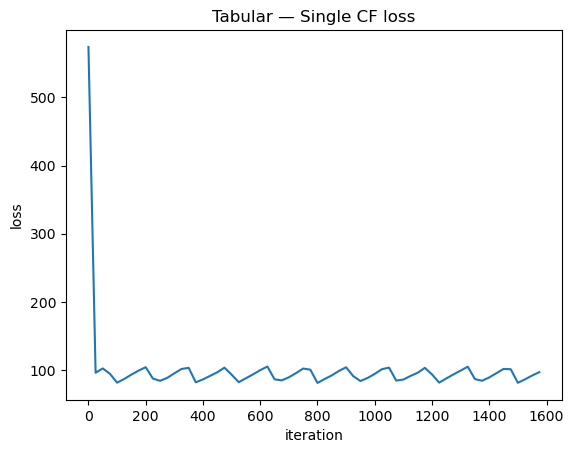

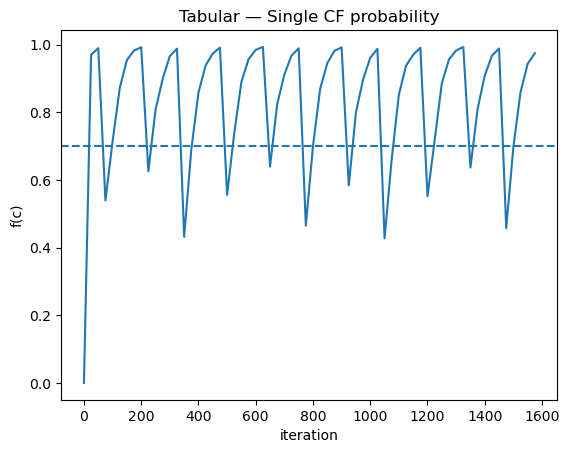

In [8]:
plt.figure()
plt.plot(hist["t"], hist["loss"])
plt.xlabel("iteration"); plt.ylabel("loss"); plt.title("Tabular — Single CF loss")
plt.show()

plt.figure()
plt.plot(hist["t"], hist["prob"])
plt.axhline(tau, linestyle="--")
plt.xlabel("iteration"); plt.ylabel("f(c)"); plt.title("Tabular — Single CF probability")
plt.show()

In [9]:
delta = c_cf - x
order = np.argsort(np.abs(delta))[::-1]
rows = []
for j in order[:12]:
    rows.append({
        "feature": feature_names[j],
        "delta": float(delta[j]),
        "x": float(x[j]),
        "c": float(c_cf[j]),
        "immutable?": (j in immutable_idx)
    })
pd.DataFrame(rows)

,feature,delta,x,c,immutable?
0,radius error,-3.320978,2.894228,-0.426750,False
1,mean concave points,-3.025563,3.373475,0.347912,False
2,worst radius,-2.720769,2.495608,-0.225161,False
3,worst concave points,-2.527949,2.627482,0.099533,False
4,worst area,-2.381760,2.570586,0.188825,False
5,worst perimeter,-2.134687,2.941726,0.807039,False
6,area error,-2.064607,2.737886,0.673279,False
7,worst fractal dimension,-1.956670,0.782138,-1.174532,False
8,worst texture,-1.932497,0.382139,-1.550358,False
9,worst symmetry,-1.923196,1.939430,0.016234,False


---

## A2 — DiCE-style: K diverse counterfactuals

### DiCE-style diversity: more details (A2)

We solve
$
\min_{c_1,\dots,c_K}\;\sum_{k=1}^K L(c_k)\;-\;\eta\,\mathrm{Div}(C),
\qquad
\mathrm{Div}(C)=\frac{2}{K(K-1)}\sum_{i<j}\|c_i-c_j\|_2.
$

**Interpretation**
- $\eta=0$: counterfactuals collapse to a similar solution.
- larger $\eta$: multiple “modes” of recourse (different actions).
- too large $\eta$: can reduce validity.

**Questions**
1. Why do we subtract diversity (instead of adding it)?  
2. Explain why validity can decrease as $\eta$ increases.  
3. Would you prefer diversity measured in $\ell_2$, cosine, or a learned embedding? Why?  
4. In a medical setting, what does “diverse counterfactuals” mean in practice?

In [11]:
def diversity_pairwise(C: np.ndarray) -> float:
# TODO: Replace L2 diversity with cosine diversity and compare.

    K = C.shape[0]
    if K <= 1:
        return 0.0
    s = 0.0
    cnt = 0
    for i in range(K):
        for j in range(i+1, K):
            s += float(np.linalg.norm(C[i]-C[j]))
            cnt += 1
    return s / cnt

def grad_diversity_pairwise(C: np.ndarray) -> np.ndarray:
    eps = 1e-8
    K = C.shape[0]
    G = np.zeros_like(C)
    cnt = 0
    for i in range(K):
        for j in range(i+1, K):
            diff = C[i]-C[j]
            nrm = float(np.linalg.norm(diff)) + eps
            g = diff / nrm
            G[i] += g
            G[j] -= g
            cnt += 1
    return G / max(cnt, 1)

def metrics_set(C: np.ndarray, x: np.ndarray, tau: float, tol: float = 1e-3) -> dict:
    probs = np.array([prob(C[k]) for k in range(C.shape[0])], dtype=float)
    return {
        "validity": float(np.mean(probs >= tau)),
        "proximity_L2": float(np.mean([np.linalg.norm(C[k]-x) for k in range(C.shape[0])])),
        "sparsity(#features)": float(np.mean([np.sum(np.abs(C[k]-x) > tol) for k in range(C.shape[0])])),
        "diversity": float(diversity_pairwise(C)),
        "probs": probs
    }

def projected_gd_set(x: np.ndarray, K: int,
                     tau: float, lam: float, gamma: float,
                     eta: float, lr: float, steps: int, seed: int = 0):
    rng = np.random.default_rng(seed)
    C = x[None,:] + 0.05*rng.standard_normal(size=(K, x.shape[0]))
    for k in range(K):
        C[k] = project_constraints(C[k], x, lower, upper, immutable_idx)

    hist = {"t": [], "div": [], "valid": []}
    for t in range(steps):
        G = np.zeros_like(C)
        for k in range(K):
            G[k] = grad_single(C[k], x, tau, lam, gamma)

        G_total = G - eta*grad_diversity_pairwise(C)
        C = C - lr*G_total

        for k in range(K):
            C[k] = project_constraints(C[k], x, lower, upper, immutable_idx)

        if t % 60 == 0:
            hist["t"].append(t)
            hist["div"].append(diversity_pairwise(C))
            hist["valid"].append(metrics_set(C, x, tau)["validity"])
    return C, hist

In [12]:
tau = 0.7
# TODO: Change tau, lam, gamma, lr, steps. What trade-offs do you observe?

etas = [0.0, 1.0, 2.0, 5.0]
# TODO: Sweep eta more finely (e.g., np.linspace(0,6,13)) and redo the plots.

K = 5

C_by_eta = {}
rows = []
for eta in etas:
    C, histC = projected_gd_set(x, K=K, tau=tau, lam=25.0, gamma=0.02, eta=eta, lr=0.02, steps=2400, seed=1)
    C_by_eta[eta] = (C, histC)
    m = metrics_set(C, x, tau)
    m["eta"] = eta
    rows.append(m)

df = pd.DataFrame(rows).sort_values("eta")
df[["eta","validity","proximity_L2","sparsity(#features)","diversity"]]

,eta,validity,proximity_L2,sparsity(#features),diversity
0,0.0,1.0,10.054966,27.0,0.021432
1,1.0,0.8,9.439687,27.0,0.654335
2,2.0,0.8,9.532065,27.0,0.673847
3,5.0,1.0,9.661971,27.0,1.241694


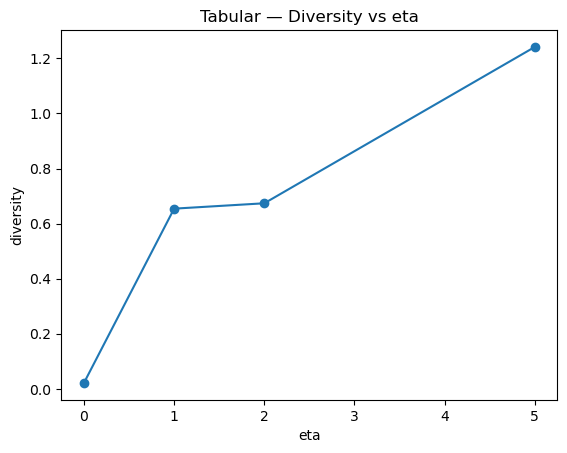

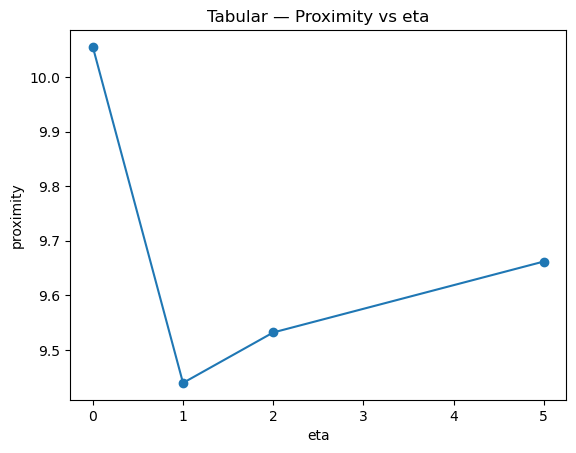

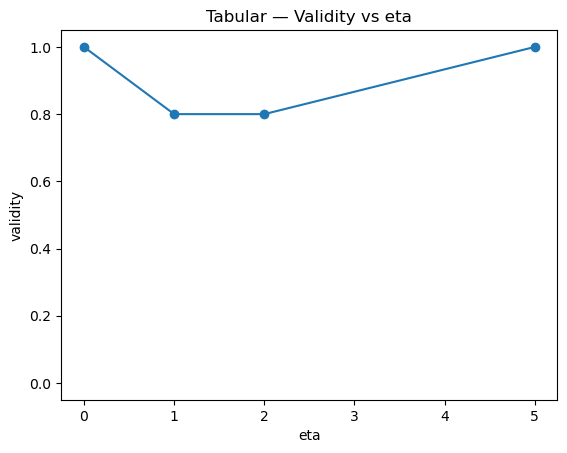

In [13]:
plt.figure()
plt.plot(df["eta"], df["diversity"], marker="o")
plt.xlabel("eta"); plt.ylabel("diversity"); plt.title("Tabular — Diversity vs eta")
plt.show()

plt.figure()
plt.plot(df["eta"], df["proximity_L2"], marker="o")
plt.xlabel("eta"); plt.ylabel("proximity"); plt.title("Tabular — Proximity vs eta")
plt.show()

plt.figure()
plt.plot(df["eta"], df["validity"], marker="o")
plt.xlabel("eta"); plt.ylabel("validity"); plt.title("Tabular — Validity vs eta")
plt.ylim(-0.05, 1.05)
plt.show()

## A3 — Plausibility proxy: kNN distance

### Plausibility proxy via kNN (A3)

We compute
$
d_{NN}(c)=\min_{x^{(i)}\in\mathcal{D}_{train}}\|c-x^{(i)}\|_2.
$

**Questions**
1. Give a counterexample where kNN distance is small but the CF is still implausible.  
2. What happens to kNN distances as dimension $D$ grows?  
3. How could you build a better plausibility term using a generative model?

In [14]:
nn = NearestNeighbors(n_neighbors=1).fit(X_train_s)

rows = []
for eta in etas:
    C, _ = C_by_eta[eta]
    d_nn, _ = nn.kneighbors(C)
    rows.append({
        "eta": eta,
        "mean_NN_dist": float(np.mean(d_nn)),
        "max_NN_dist": float(np.max(d_nn)),
        "min_NN_dist": float(np.min(d_nn)),
    })
pd.DataFrame(rows).sort_values("eta")

,eta,mean_NN_dist,max_NN_dist,min_NN_dist
0,0.0,6.718510,6.724240,6.709914
1,1.0,6.428916,6.743957,6.158615
2,2.0,6.477363,6.785726,6.173446
3,5.0,6.557998,6.739904,6.250466


---

# Bridge: from tabular to images

In Part A, the counterfactual problem was **feature-based**: each coordinate of $x\in\mathbb{R}^D$ is a named measurement (radius, texture, …).

In Part B, the exact same optimization applies, but the “features” are **pixels** (or groups of pixels).

## Reminder: single counterfactual objective

Given a target threshold $\tau$, define the logit threshold
$
\kappa = \log\frac{\tau}{1-\tau}.
$

For logistic regression with score $s(c)=w^\top c + b$, validity is
$
f(c)\ge\tau \iff s(c)\ge\kappa.
$

We optimize
$
\min_{c\in\mathcal{C}}\;
\lambda\,\max(0,\kappa-s(c))
+\underbrace{\|c-x\|_2^2}_{\text{proximity}}
+\underbrace{\gamma\|c-x\|_1}_{\text{sparsity}}.
$

## What changes for images?

- **Interpretability:** proximity in $\ell_2$ does not necessarily mean “visually close”.
- **Artifacts:** unconstrained pixel changes can look like “salt-and-pepper”.
- **Fix:** add an image prior such as Total Variation (TV) to encourage smooth perturbations:
$
L_{\text{img}}(c)=L(c)+\beta\,\mathrm{TV}(\mathrm{reshape}(c)).
$

---

# Part B — Image application: Digits (8×8)

### Image section — guiding questions (B)

Images: pixels as features
$
x\in\mathbb{R}^{64}\quad\leftrightarrow\quad 8\times 8 \text{ image}.
$

**Questions**
1. Is $\|c-x\|_2$ a good proxy for perceptual similarity? Why/why not?  
2. What could “immutable features” mean for images?  
3. If box constraints are too loose, what artifacts do you expect?

In [15]:
digits = load_digits()
# TODO: Choose a different target digit (e.g., target==7) and re-run the whole image section.

Ximg = digits.data.astype(float)
yimg = (digits.target == 0).astype(int)

Xtr, Xte, ytr, yte = train_test_split(
# TODO: Try different test_size / random_state and observe AUC/accuracy.
Ximg, yimg, test_size=0.25, random_state=0, stratify=yimg)

sc_img = StandardScaler()
Xtr_s = sc_img.fit_transform(Xtr)
Xte_s = sc_img.transform(Xte)

clf_img = LogisticRegression(max_iter=3000)
clf_img.fit(Xtr_s, ytr)

p_te = clf_img.predict_proba(Xte_s)[:,1]
pred_te = (p_te >= 0.5).astype(int)

print("Digits accuracy:", accuracy_score(yte, pred_te))

Digits accuracy: 0.9977777777777778


True label: 0   f(x): 2.1155823088322075e-10


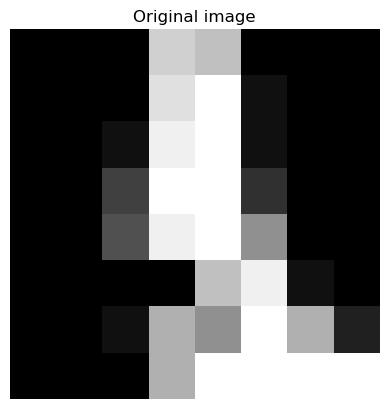

In [16]:
idx_img = int(np.argmin(p_te))
x_img = Xte_s[idx_img].copy()
y_img_true = int(yte[idx_img])
p_img0 = float(clf_img.predict_proba(x_img.reshape(1,-1))[0,1])

print("True label:", y_img_true, "  f(x):", p_img0)

plt.imshow(sc_img.inverse_transform(x_img.reshape(1,-1))[0].reshape(8,8), cmap="gray")
plt.title("Original image")
plt.axis("off")
plt.show()

In [17]:
w_img = clf_img.coef_.reshape(-1)
b_img = float(clf_img.intercept_[0])

def score_img(z): return float(np.dot(w_img, z) + b_img)
def prob_img(z): return float(1.0/(1.0+np.exp(-score_img(z))))

lower_img = np.quantile(Xtr_s, 0.01, axis=0)
upper_img = np.quantile(Xtr_s, 0.99, axis=0)
def project_img(c): return np.clip(c, lower_img, upper_img)

def loss_single_img(c, x, tau, lam, gamma):
    kappa = logit(tau)
    s = score_img(c)
    return lam*max(0.0, kappa - s) + float(np.sum((c-x)**2)) + gamma*float(np.sum(np.abs(c-x)))

def grad_single_img(c, x, tau, lam, gamma):
    kappa = logit(tau)
    s = score_img(c)
    g = 2.0*(c-x) + gamma*np.sign(c-x)
    if s < kappa:
        g += lam * (-w_img)
    return g

def pgd_single_img(
# TODO: For images, try patching: optimize over 4x4 tiles instead of pixels.
x, tau=0.7, lam=35.0, gamma=0.05, lr=0.02, steps=1800, seed=0):
    rng = np.random.default_rng(seed)
    c = project_img(x + 0.01*rng.standard_normal(size=x.shape))
    hist={"t": [], "prob": [], "loss": []}
    for t in range(steps):
        c = c - lr*grad_single_img(c, x, tau, lam, gamma)
        c = project_img(c)
        if t % 40 == 0:
            hist["t"].append(t)
            hist["prob"].append(prob_img(c))
            hist["loss"].append(loss_single_img(c, x, tau, lam, gamma))
    return c, hist

tau_img = 0.7
c_img_cf, hist_img = pgd_single_img(x_img, tau=tau_img, lam=35.0, gamma=0.05, lr=0.02, steps=1800, seed=0)

print("Initial f(x):", prob_img(x_img))
print("Final   f(c):", prob_img(c_img_cf))

Initial f(x): 2.1155823088322075e-10
Final   f(c): 0.8383981711437741


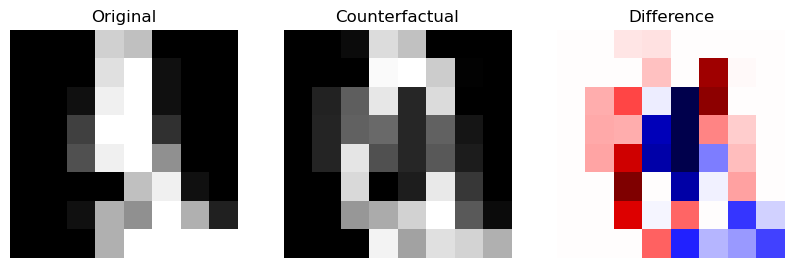

In [18]:
xraw = sc_img.inverse_transform(x_img.reshape(1,-1))[0].reshape(8,8)
craw = sc_img.inverse_transform(c_img_cf.reshape(1,-1))[0].reshape(8,8)
diff = craw - xraw

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(xraw, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(craw, cmap="gray"); plt.title("Counterfactual"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(diff, cmap="seismic"); plt.title("Difference"); plt.axis("off")
plt.show()

## B2 — Image-specific regularization: Total Variation (TV)

We add:
$
L_{img}(c)=L(c)+\beta\,\mathrm{TV}(\mathrm{reshape}(c)).
$

### Total Variation (TV) prior (B2)

For $C\in\mathbb{R}^{8\times 8}$:
$
\mathrm{TV}(C)=\sum_{i=1}^{7}\sum_{j=1}^{8}|C_{i+1,j}-C_{i,j}|
+\sum_{i=1}^{8}\sum_{j=1}^{7}|C_{i,j+1}-C_{i,j}|.
$

We optimize
$
L_{\text{img}}(c)=L(c)+\beta\,\mathrm{TV}(\mathrm{reshape}(c)).
$

**Questions**
1. What happens as $\beta\to\infty$?  
2. TV is non-differentiable. Why can we still use subgradients?  
3. Compare TV vs a Gaussian smoothness penalty (which preserves edges better?).



In [ ]:
def tv_loss(img):
    dx = img[1:,:] - img[:-1,:]
    dy = img[:,1:] - img[:,:-1]
    return float(np.sum(np.abs(dx)) + np.sum(np.abs(dy)))

def tv_subgrad(img):
    g = np.zeros_like(img)
    dx = img[1:,:] - img[:-1,:]
    sdx = np.sign(dx)
    g[1:,:] += sdx
    g[:-1,:] -= sdx
    dy = img[:,1:] - img[:,:-1]
    sdy = np.sign(dy)
    g[:,1:] += sdy
    g[:,:-1] -= sdy
    return g

def grad_single_img_tv(c, x, tau, lam, gamma, beta):
    g = grad_single_img(c, x, tau, lam, gamma)
    img_raw = sc_img.inverse_transform(c.reshape(1,-1))[0].reshape(8,8)
    g_tv_raw = tv_subgrad(img_raw).reshape(-1)
    scale = sc_img.scale_.reshape(-1)
    g_tv_std = g_tv_raw * scale
    return g + beta*g_tv_std

def pgd_single_img_tv(x, tau=0.7, lam=35.0, gamma=0.05, beta=0.0, lr=0.02, steps=1800, seed=0):
    rng = np.random.default_rng(seed)
    c = project_img(x + 0.01*rng.standard_normal(size=x.shape))
    for t in range(steps):
        c = c - lr*grad_single_img_tv(c, x, tau, lam, gamma, beta)
        c = project_img(c)
    return c

c_no = pgd_single_img_tv(x_img, tau=tau_img, beta=0.0, steps=1800, seed=0)
c_tv = pgd_single_img_tv(x_img, tau=tau_img, beta=0.8, steps=1800, seed=0)
# TODO: Increase beta (TV) and check when validity starts to fail.


print("No-TV prob:", prob_img(c_no))
print("TV prob   :", prob_img(c_tv))
print("TV(original):", tv_loss(sc_img.inverse_transform(x_img.reshape(1,-1))[0].reshape(8,8)))
print("TV(no-TV CF):", tv_loss(sc_img.inverse_transform(c_no.reshape(1,-1))[0].reshape(8,8)))
print("TV(TV CF)   :", tv_loss(sc_img.inverse_transform(c_tv.reshape(1,-1))[0].reshape(8,8)))

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3356683331.py, line 37)

In [ ]:
xraw = sc_img.inverse_transform(x_img.reshape(1,-1))[0].reshape(8,8)
no_raw = sc_img.inverse_transform(c_no.reshape(1,-1))[0].reshape(8,8)
tv_raw = sc_img.inverse_transform(c_tv.reshape(1,-1))[0].reshape(8,8)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(xraw, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(no_raw, cmap="gray"); plt.title("CF (no TV)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(tv_raw, cmap="gray"); plt.title("CF (with TV)"); plt.axis("off")
plt.show()

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.imshow(no_raw-xraw, cmap="seismic"); plt.title("Diff (no TV)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(tv_raw-xraw, cmap="seismic"); plt.title("Diff (with TV)"); plt.axis("off")
plt.show()